In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import Functions_GBM as GBM
import Functions_Variance as f_var
import Estimators_Functions as e_fun
from IPython.display import display

# High Frequency Data Simulation & Estimators Analysis

In this notebook, we simulate high-frequency financial time series using a **Geometric Brownian Motion (GBM)**. 
We then validate the statistical properties of the simulation (Normality of returns, Martingale property) and analyze the performance of the **Two-Scales Realized Volatility (TSRV)** estimator in the presence of microstructure noise.

### Theoretical Framework
The asset price $S_t$ follows the stochastic differential equation:
$$dS_t = \mu S_t dt + \sigma S_t dW_t$$

Where:
* $\mu$ is the drift.
* $\sigma$ is the volatility.
* $W_t$ is a Wiener process.

## 1. Simulation of Price Paths (GBM)
We simulate $N$ paths using the analytical solution of the GBM:
$$S_t = S_0 \exp\left( (\mu - \frac{1}{2}\sigma^2)t + \sigma W_t \right)$$

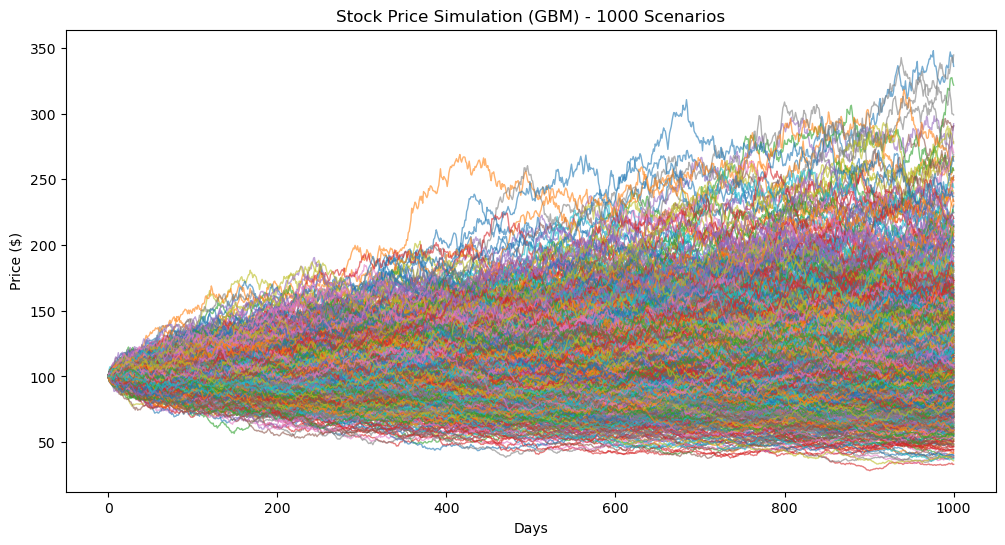

In [2]:
df_prices = GBM.sim_gbm_paths(S0=100, mu=0.05, sigma=0.2, T=1000, dt=1/252, n_paths=1000)
GBM.plot_gbm_paths(df_prices)

## 2. Statistical Validation
We verify that the Log-Returns $r_t = \ln(S_t / S_{t-1})$ follow a Normal Distribution:
$$r_t \sim \mathcal{N}\left( (\mu - \frac{1}{2}\sigma^2)\Delta t, \sigma^2 \Delta t \right)$$

We compute the first four moments (Mean, Variance, Skewness, Kurtosis) and perform the **Jarque-Bera test** to validate the normality assumption.

In [3]:
GBM.statistics_gbm(df_prices)

       EMPIRICAL GBM STATISTICS (Log-Returns)
Paths Drifts Mean:      0.000099
Paths Variance Mean:  0.000159
Paths Skewness Mean:   -0.0011
Paths Kurtosis Mean:   -0.0065
Normal Returns Assumption Validated through Jarque-Bera Test.


,Mean,Variance,Skewness,Kurtosis
0,0.001212,0.000157,0.134587,-0.033223
1,-0.000335,0.000150,0.016486,-0.029274
2,-0.000075,0.000171,0.000809,0.056469
3,0.000283,0.000170,-0.214088,-0.012803
4,0.000269,0.000154,-0.036283,-0.082781
...,...,...,...,...
995,0.000316,0.000158,0.030172,0.045352
996,0.000220,0.000162,0.075169,-0.015105
997,-0.000118,0.000156,-0.046555,-0.056323
998,0.000330,0.000162,-0.056461,0.173737


In [4]:
rv = f_var.calculate_rv_per_path(df_prices)
display(pd.DataFrame(rv, columns=["Realized Volatility"]))
print("=" * 80)
rv_mean = f_var.calculate_mean_rv(rv)

The Realized Volatility for each simulated path is:


,Realized Volatility
0,0.158449
1,0.149801
2,0.171134
3,0.169664
4,0.153591
...,...
995,0.158068
996,0.162370
997,0.155528
998,0.161518


The Mean Realized Volatility between all simulated paths is: 0.15879963830905433


## 3. Martingale Property Test
The discounted price process $\tilde{S}_t = e^{-\mu t} S_t$ must be a martingale under the measure $\mathbb{P}$:
$$\mathbb{E}[\tilde{S}_t | \mathcal{F}_0] = S_0$$

We verify this property in two ways:
1.  **Visual Inspection:** Checking if the mean of the simulated discounted paths converges to the initial price $S_0$.
2.  **Statistical Test:** Performing a T-test on the final values to ensure there is no significant bias.

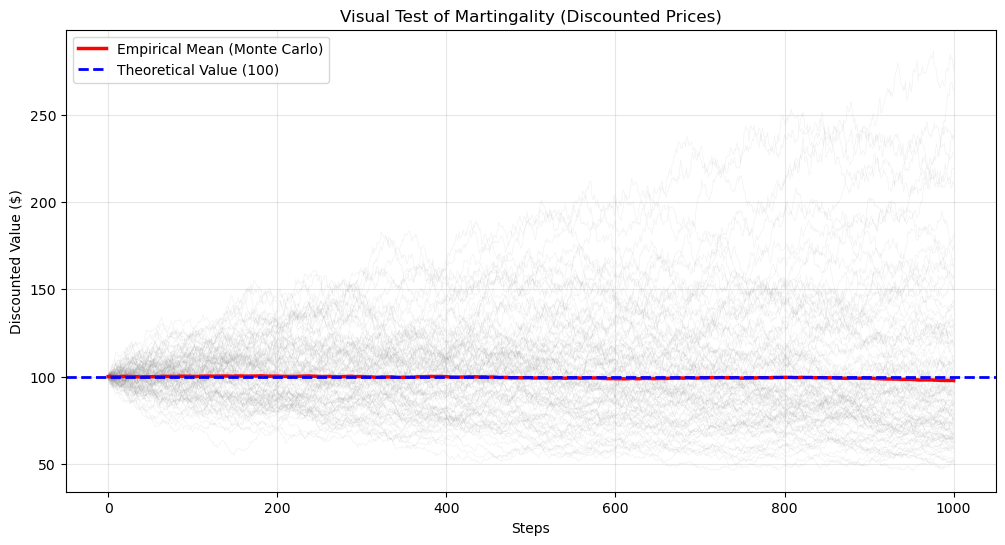

In [5]:
mart_paths, mart_mean = GBM.martingale(df_prices, dt=1/252, mu=0.05)
GBM.plot_martingale_test(mart_paths, mart_mean, S0=100)

In [6]:
GBM.test_martingale_statistics(mart_paths, S0=100)

       MARTINGALITY T-TESTS ON DISCOUNTED PRICES       
Final Empirical Mean: 97.7320 (Target: 100)
T-Statistic: -1.8366
P-Value:     0.0666
>> Do not Reject H0. IT IS A MARTINGALE.


## 4. Two-Scales Realized Volatility (TSRV)
We introduce **microstructure noise** $\epsilon_t \sim \mathcal{N}(0, \eta^2)$ to the efficient price $X_t$ (log-price) to simulate real-world high-frequency data:
$$Y_t = X_t + \epsilon_t$$

We compare two estimators:
1.  **Realized Volatility (RV):** Which is biased and inconsistent under noise.
2.  **TSRV:** Which corrects for the bias using subsampling (Fast and Slow time scales).

### 4.1 Optimization of Sparse Parameter ($K$)
The TSRV estimator depends on a sparsity parameter $K$ (or $n_{sparse}$). We perform a **Grid Search** to find the optimal $K$ that minimizes the Mean Squared Error (MSE) against the true Integrated Volatility.

In [7]:
noisy_prices = e_fun.add_micro_noise(df_prices, n_paths=1000)
# qui sopra checkare che non venga aggiunto il noise alla prima riga
rv_naive = f_var.calculate_mean_rv2(f_var.calculate_rv_per_path2(noisy_prices))
rv_sparse = f_var.calculate_mean_rv2(f_var.calculate_rv_per_path2(noisy_prices[::300]))
tsrv = np.array(e_fun.tsrv_estimator(noisy_prices, K=300))
print("=" * 103)
print(f"The Naive Estimator for Integrated Volatility is: {rv_naive}")
print("=" * 103)
print(f"The Sparse Estimator for Integrated Volatility is: {rv_sparse}. (every 300 obs.)")
print("=" * 103)
print(f"The Zhang Estimator for Integrated Volatility (with K=300, standard literature) is: {tsrv}")
print("=" * 103)
err_tsrv = e_fun.calculate_error(tsrv, rv_mean)
print(f"TSRV Error: {err_tsrv*100:.2f}%")


The Naive Estimator for Integrated Volatility is: 0.15880573824116706
The Sparse Estimator for Integrated Volatility is: 0.1427575318308129. (every 300 obs.)
The Zhang Estimator for Integrated Volatility (with K=300, standard literature) is: 0.11251317483622611
TSRV Error: 29.15%


In [8]:
df_results = e_fun.generate_tsrv_table(
    prices=noisy_prices, 
    true_iv=rv_naive, 
    k_range=range(2 ,500, 2), 
    k_chosen=300
)
display(df_results)

,Optimal K,TSRV (Optimal K),TSRV (K=300)
0,2,0.158607,0.112513
1,2,0.158607,0.112513
2,2,0.158607,0.112513
3,2,0.158607,0.112513
4,2,0.158607,0.112513
...,...,...,...
995,2,0.158607,0.112513
996,2,0.158607,0.112513
997,2,0.158607,0.112513
998,2,0.158607,0.112513


### 4.2 Consistency Check: Volatility Signature Plot
We analyze the behavior of the estimators as the sampling frequency $N$ increases (from low frequency to ultra-high frequency).

* **RV Consistency:** We expect RV to diverge as $N \to \infty$ due to noise accumulation.
* **TSRV Consistency:** We expect TSRV to remain stable and converge to the True Integrated Volatility.

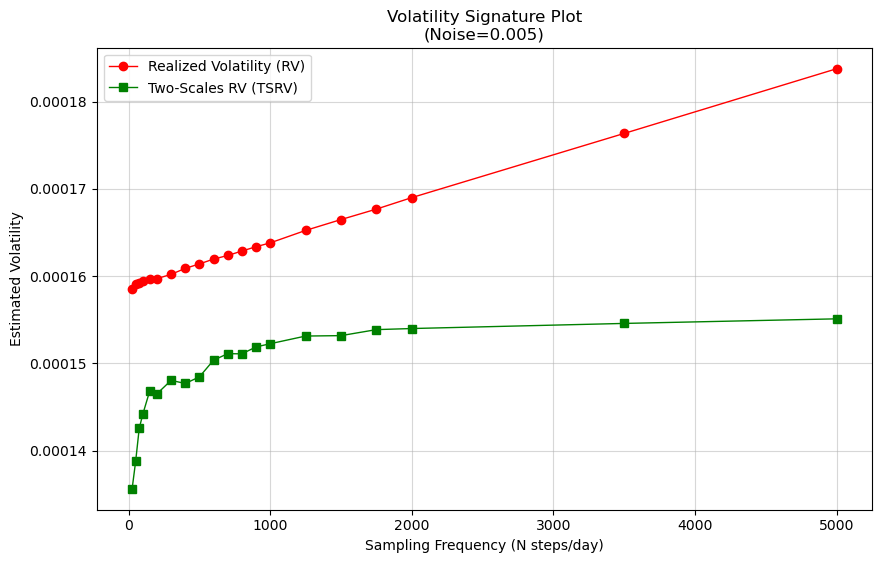

In [9]:
e_fun.plot_consistency_check(0.05, 0.2, 100, 0.005, n_paths=1000)